## 实验：实现卷积神经网络

### 实验概要

卷积神经网络和常规神经网络非常相似：它们都是由神经元组成，神经元中有具有学习能力的权重和偏差。每个神经元都得到一些输入数据，进行内积运算后再进行激活函数运算。整个网络依旧是一个可导的评分函数：该函数的输入是原始的图像像素，输出是不同类别的评分。在最后一层（**往往是全连接层**），网络依旧有一个损失函数（比如 SVM 或 Softmax），并且在神经网络中我们实现的各种技巧和要点依旧适用于卷积神经网络。

那么有哪些地方变化了呢？卷积神经网络的结构基于一个假设，即输入数据是图像，基于该假设，我们就向结构中添加了一些特有的性质。这些特有属性使得前向传播函数实现起来更高效，并且大幅度降低了网络中参数的数量。

#### 卷积神经网络结构概述

##### 常规神经网络。

神经网络的输入是一个向量，然后在一系列的隐层中对它做变换。每个 **隐藏层** 都是由若干的神经元组成，每个神经元都与前一层中的所有神经元连接。但是在一个 **隐藏层** 中，神经元相互独立不进行任何连接。最后的全连接层被称为 **输出层**，在分类问题中，它输出的值被看做是不同类别的评分值。

常规神经网络对于大尺寸图像效果不尽人意。在 CIFAR-10 中，图像的尺寸是 `32x32x3`（宽高均为 `32` 像素，`3` 个颜色通道），因此，对应的的常规神经网络的第一个 **隐藏层** 中，每一个单独的全连接神经元就有 `32x32x3=3072` 个权重。这个数量看起来还可以接受，但是很显然这个全连接的结构不适用于更大尺寸的图像。举例说来，一个尺寸为 `200x200x3` 的图像，会让神经元包含 `200x200x3=120,000` 个权重值。而网络中肯定不止一个神经元，那么参数的量就会快速增加！显而易见，这种全连接方式效率低下，大量的参数也很快会导致网络过拟合。

#####  神经元的三维排列

卷积神经网络针对输入全部是图像的情况，将结构调整得更加合理，获得了不小的优势。与常规神经网络不同，卷积神经网络的各层中的神经元是三维排列的：**宽度、高度和深度**（这里的 **深度** 指的是激活数据体的第三个维度，而不是整个网络的深度，整个网络的深度指的是网络的层数）。举个例子，CIFAR-10 中的图像是作为卷积神经网络的输入，该数据体的维度是 `32x32x3`（**宽度，高度和深度**）。我们将看到，层中的神经元将只与前一层中的一小块区域连接，而不是采取全连接方式。对于用来分类 CIFAR-10 中的图像的卷积网络，其最后的输出层的维度是 `1x1x10`，因为在卷积神经网络结构的最后部分将会把全尺寸的图像压缩为包含分类评分的一个向量，向量是在深度方向排列的。下面是例子：

![](./img/1_22.jpg)

*左边是一个三层的神经网络。右边是一个卷积神经网络，图例中网络将它的神经元都排列成三个维度（**宽、高和深度**）。卷积神经网络的每一层都将 3D 的输入数据变化为神经元 3D 的激活数据并输出。在这个例子中，红色的输入层装的是图像，所以它的宽度和高度就是图像的宽度和高度，它的深度是 `3`（代表了红、绿、蓝三种颜色通道）。*

> 卷积神经网络是由层组成的。每一层都有一个简单的 API：用一些含或者不含参数的可导的函数，将输入的 3D 数据变换为 3D 的输出数据。

#### 构建卷积神经网络的各种层

一个简单的卷积神经网络是由各种层按照顺序排列组成，网络中的每个层使用一个可以微分的函数将激活数据从一个层传递到另一个层。卷积神经网络主要由三种类型的层构成：

- **卷积（Convolutional）层**
- **汇聚/池化（Pooling）层**
- **全连接（Fully-Connected）层（全连接层和常规神经网络中的一样）**

通过将这些层叠加起来，就可以构建一个完整的卷积神经网络。我们先举一个网络结构例子：这仅仅是个概述，下面会更详解的介绍细节。

一个用于 CIFAR-10 图像数据分类的卷积神经网络的结构可以是：**`[输入层-卷积层-ReLU层-汇聚层-全连接层]`**，细节如下：

- **输入：** `[32x32x3]` 存有图像的原始像素值，本例中图像宽高均为 `32`，有三个颜色通道。
- **卷积层：** 神经元与输入层中的一个局部区域相连，每个神经元都计算自己与输入层相连的小区域与自己权重的内积。卷积层会计算所有神经元的输出。如果我们使用 `12` 个滤波器（也叫作核），得到的输出数据体的维度就是 `[32x32x12]`。
- **ReLU 层：** 将会逐个元素地进行激活函数操作，比如使用以 `0` 为阈值的 $\max (0, x)$ 作为激活函数。该层对数据尺寸没有改变，还是 `[32x32x12]`。
- **汇聚层：** 会在空间维度（宽度和高度）上进行降采样（downsampling）操作，数据尺寸变为 `[16x16x12]`。
- **全连接层：** 将会计算分类评分，数据尺寸变为 `[1x1x10]`，其中 **10** 个数字对应的就是 CIFAR-10 中 **10** 个类别的分类评分值。正如其名，全连接层与常规神经网络一样，其中每个神经元都与前一层中所有神经元相连接。

由此看来，卷积神经网络一层一层地将图像从原始像素值变换成最终的分类评分值。其中有的层含有参数，有的没有。具体说来，卷积层和全连接层（CONV/FC）对输入执行变换操作的时候，不仅会用到激活函数，还会用到很多参数（神经元的突触权值和偏差）。而 ReLU 层和汇聚层则是进行一个固定不变的函数操作。卷积层和全连接层中的参数会随着梯度下降被训练，这样卷积神经网络计算出的分类评分就能和训练集中的每个图像的标签吻合了。

**小结一下：**

- 简单案例中卷积神经网络的结构，就是一系列的层将输入数据变换为输出数据（比如分类评分）。
- 卷积神经网络结构中有几种不同类型的层（目前最流行的有卷积层、全连接层、ReLU 层和汇聚层）。
- 每个层的输入是3D数据，然后使用一个可导的函数将其变换为 3D 的输出数据。
- 有的层有参数，有的没有（卷积层和全连接层有，ReLU 层和汇聚层没有）。
- 有的层有额外的超参数，有的没有（卷积层、全连接层和汇聚层有，ReLU 层没有）。

<img src="./img/2_22.jpg" width="75%">

*上图是一个卷积神经网络的激活输出例子。左边的输入层存有原始图像像素，右边的输出层存有类别分类评分。在处理流程中的每个激活数据体是铺成一列来展示的。因为对 3D 数据作图比较困难，我们就把每个数据体切成层，然后铺成一列显示。最后一层装的是针对不同类别的分类得分，这里只显示了得分最高的 5 个评分值和对应的类别。本例中的结构是一个小的 VGG 网络，VGG 网络后面会有讨论。*

下面，讲解不同的层，层的超参数和连接情况的细节。

##### 卷积层 ( Convolutional Layer )

卷积层是构建卷积神经网络的核心层，它产生了网络中大部分的计算量。

**概述和直观介绍：** 首先讨论的是，在没有大脑和生物意义上的神经元之类的比喻下，卷积层到底在计算什么。卷积层的参数是有一些可学习的滤波器集合构成的。每个滤波器在空间上（宽度和高度）都比较小，但是深度和输入数据一致。举例来说，卷积神经网络第一层的一个典型的滤波器的尺寸可以是 `5x5x3`（宽高都是 `5` 像素，深度是 `3` 是因为图像应为颜色通道，所以有 `3` 的深度）。在前向传播的时候，让每个滤波器都在输入数据的宽度和高度上滑动（更精确地说是卷积），然后计算整个滤波器和输入数据任一处的内积。当滤波器沿着输入数据的宽度和高度滑过后，会生成一个 **二维的激活图（activation map）**，激活图给出了在每个空间位置处滤波器的反应。直观地来说，网络会让滤波器学习到当它看到某些类型的视觉特征时就激活，具体的视觉特征可能是某些方位上的边界，或者在第一层上某些颜色的斑点，甚至可以是网络更高层上的蜂巢状或者车轮状图案。

在每个卷积层上，我们会有一整个集合的滤波器（比如 `12` 个），每个都会生成一个不同的二维激活图。将这些激活映射在深度方向上层叠起来就生成了输出数据。

**以大脑做比喻：** 如果你喜欢用大脑和生物神经元来做比喻，那么输出的 3D 数据中的每个数据项可以被看做是神经元的一个输出，而该神经元只观察输入数据中的一小部分，并且和空间上左右两边的所有神经元共享参数（因为这些数字都是使用同一个滤波器得到的结果）。现在开始讨论神经元的连接，它们在空间中的排列，以及它们参数共享的模式。

**局部连接：** 在处理图像这样的高维度输入时，让每个神经元都与前一层中的所有神经元进行全连接是不现实的。相反，我们让每个神经元只与输入数据的一个局部区域连接。该连接的空间大小叫做神经元的 **感受野（receptive field）**，它的尺寸是一个超参数（其实就是滤波器的空间尺寸）。在深度方向上，这个连接的大小总是和输入量的深度相等。**需要再次强调的是，我们对待空间维度（宽和高）与深度维度是不同的：连接在空间（宽高）上是局部的，但是在深度上总是和输入数据的深度一致**。

> ***例1：*** 假设输入数据体尺寸为 `[32x32x3]`（比如 CIFAR-10 的 RGB 图像），如果感受野（或滤波器尺寸）是 `5x5`，那么卷积层中的每个神经元会有输入数据体中 `[5x5x3]` 区域的权重，共 `5x5x3=75` 个权重（还要加一个偏差参数）。注意这个连接在深度维度上的大小必须为 `3`，和输入数据体的深度一致。

> ***例2：*** 假设输入数据体的尺寸是 `[16x16x20]`，感受野尺寸是 `3x3`，那么卷积层中每个神经元和输入数据体就有 `3x3x20=180` 个连接。**再次提示：** 在空间上连接是局部的（`3x3`），但是在深度上是和输入数据体一致的（`20`）。

<img src="./img/3_22.jpg" width="75%">

***左边：*** *红色的是输入数据体（比如 CIFAR-10 中的图像），蓝色的部分是第一个卷积层中的神经元。卷积层中的每个神经元都只是与输入数据体的一个局部在空间上相连，但是与输入数据体的所有深度维度全部相连（所有颜色通道）。在深度方向上有多个神经元（本例中 5 个），它们都接受输入数据的同一块区域（感受野相同）。至于深度列的讨论在下文中有。* ***右边：*** *神经网络章节中介绍的神经元保持不变，它们还是计算权重和输入的内积，然后进行激活函数运算，只是它们的连接被限制在一个局部空间。*

**空间排列：** 上文讲解了卷积层中每个神经元与输入数据体之间的连接方式，但是尚未讨论输出数据体中神经元的数量，以及它们的排列方式。3个超参数控制着输出数据体的尺寸：**深度（depth）**，**步长（stride）** 和 **零填充（zero-padding）**。下面是对它们的解释：

1. 首先，输出数据体的深度是一个超参数：它和使用的滤波器的数量一致，而每个滤波器在输入数据中寻找一些不同的东西。举例来说，如果第一个卷积层的输入是原始图像，那么在深度维度上的不同神经元将可能被不同方向的边界，或者是颜色斑点激活。我们将这些沿着深度方向排列、感受野相同的神经元集合称为 **深度列（depth column）**，也有人使用纤维（fibre）来称呼它们。
2. 其次，在滑动滤波器的时候，必须指定步长。当步长为 1，滤波器每次移动 1 个像素。当步长为 2（或者不常用的 3，或者更多，这些在实际中很少使用），滤波器滑动时每次移动 2 个像素。这个操作会让输出数据体在空间上变小。
3. 在下文可以看到，有时候将输入数据体用0在边缘处进行填充是很方便的。这个 **零填充（zero-padding）** 的尺寸是一个超参数。零填充有一个良好性质，即可以控制输出数据体的空间尺寸（最常用的是用来保持输入数据体在空间上的尺寸，这样输入和输出的宽高都相等）。

输出数据体在空间上的尺寸可以通过输入数据体尺寸（$W$），卷积层中神经元的感受野尺寸（$F$），步长（$S$）和零填充的数量（$P$）的函数来计算。（*注：这里假设输入数组的空间形状是正方形，即高度和宽度相等*）输出数据体的空间尺寸为 $(W-F +2P)/S+1$。比如：输入是 `7x7`，滤波器是 `3x3`，步长为 `1`，填充为 `0`，那么就能得到一个 `5x5` 的输出。如果步长为 `2`，输出就是 `3x3`。下面是例子：

![](./img/4_22.jpg)

上图为空间排列的图示。在本例中只有一个空间维度（x 轴），神经元的感受野尺寸 `F=3`，输入尺寸 `W=5`，零填充 `P=1`。

- 左边：神经元使用的步长 `S=1`，所以输出尺寸是 `(5-3+2)/1+1=5`。
- 右边：神经元的步长 `S=2`，则输出尺寸是 `(5-3+2)/2+1=3`。注意当步长 `S=3` 时是无法使用的，因为它无法整齐地穿过数据体。从等式上来说，因为 `(5-3+2)=4` 是不能被 `3` 整除的。

本例中，神经元的权重是 `[1,0,-1]`，显示在图的右上角，偏差值为 `0`。这些权重是被所有黄色的神经元共享的（参数共享的内容看下文相关内容）。

**使用零填充：** 在上面左边例子中，注意输入维度是 `5`，输出维度也是 `5`。之所以如此，是因为感受野是 `3` 并且使用了 `1` 的零填充。如果不使用零填充，则输出数据体的空间维度就只有 `3`，因为这就是滤波器整齐滑过并覆盖原始数据需要的数目。一般说来，当步长 $S=1$ 时，零填充的值是 $P=(F−1)/2 $，这样就能保证输入和输出数据体有相同的空间尺寸。这样做非常常见，在介绍卷积神经网络的结构的时候我们会详细讨论其原因。

**步长的限制：** 注意这些空间排列的超参数之间是相互限制的。举例说来，当输入尺寸 $W=10$，不使用零填充则 $P=0$，滤波器尺寸 $F=3 $，这样步长 $S=2$ 就行不通，因为 $(W−F+2P)/S+1=(10−3+0)/2+1=4.5$，结果不是整数，这就是说神经元不能整齐对称地滑过输入数据体。因此，这些超参数的设定就被认为是无效的，一个卷积神经网络库可能会报出一个错误，或者修改零填充值来让设置合理，或者修改输入数据体尺寸来让设置合理，或者其他什么措施。在后面的卷积神经网络结构小节中，你可以看到合理地设置网络的尺寸让所有的维度都能正常工作，这件事可是相当让人头痛的。而使用零填充和遵守其他一些设计策略将会有效解决这个问题。

譬如：[Krizhevsky 架构](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) 赢得了 2012 年的 ImageNet 挑战，其输入图像的尺寸是 `[227x227x3]`。在第一个卷积层，神经元使用的感受野尺寸 $F=11 $，步长 $S=4$，不使用零填充 $P=0$。因为 `(227-11)/4+1=55`，卷积层的深度 $K=96 $，则卷积层的输出数据体尺寸为 `[55x55x96]`。`55x55x96` 个神经元中，每个都和输入数据体中一个尺寸为 `[11x11x3]` 的区域全连接。在深度列上的 `96` 个神经元都是与输入数据体中同一个 `[11x11x3]` 区域连接，但是权重不同。有一个有趣的细节，在原论文中，说的输入图像尺寸是 `224x224`，这是肯定错误的，因为 `(224-11)/4+1` 的结果不是整数。这件事在卷积神经网络的历史上让很多人迷惑，而这个错误到底是怎么发生的没人知道。估计是 Alex 忘记在论文中指出自己使用了尺寸为 `3` 的额外的零填充。

**参数共享：** 在卷积层中使用参数共享是用来控制参数的数量。就用上面的例子，在第一个卷积层就有 `55x55x96=290,400` 个神经元，每个有 `11x11x3=364` 个参数和 `1` 个偏置。将这些合起来就是 ·290400x364=105,705,600· 个参数。单单第一层就有这么多参数，显然这个数目是非常大的。

作一个合理的假设：如果一个特征在计算某个空间位置 `(x,y)` 的时候有用，那么它在计算另一个不同位置 `(x2,y2)` 的时候也有用。基于这个假设，可以显著地减少参数数量。换言之，就是将深度维度上一个单独的2维切片看做 **深度切片（depth slice）**，比如一个数据体尺寸为 `[55x55x96]` 的就有 `96` 个深度切片，每个尺寸为 `[55x55]`。在每个深度切片上的神经元都使用同样的权重和偏差。在这样的参数共享下，例子中的第一个卷积层就只有 `96` 个不同的权重集了，一个权重集对应一个深度切片，共有 `96x11x11x3=34,848` 个不同的权重，或 `34,944`个参数（ `+96` 个偏差）。在每个深度切片中的 `55x55` 个权重使用的都是同样的参数。在反向传播的时候，都要计算每个神经元对它的权重的梯度，但是需要把同一个深度切片上的所有神经元对权重的梯度累加，这样就得到了对共享权重的梯度。这样，每个切片只更新一个权重集。

注意，如果在一个深度切片中的所有权重都使用同一个权重向量，那么卷积层的前向传播在每个深度切片中可以看做是在计算神经元权重和输入数据体的 **卷积**（这就是 **卷积层** 名字由来）。这也是为什么总是将这些权重集合称为 **滤波器（filter**）（或 **卷积核（kernel）**），因为它们和输入进行了卷积。

![](./img/5_22.jpg)

*以上是 Krizhevsky 等学习到的滤波器例子。这 `96` 个滤波器的尺寸都是 `[11x11x3]`，在一个深度切片中，每个滤波器都被 `55x55` 个神经元共享。注意参数共享的假设是有道理的：如果在图像某些地方探测到一个水平的边界是很重要的，那么在其他一些地方也会同样是有用的，这是因为图像结构具有平移不变性。所以在卷积层的输出数据体的 `55x55` 个不同位置中，就没有必要重新学习去探测一个水平边界了。*

注意有时候参数共享假设可能没有意义，特别是当卷积神经网络的输入图像是一些明确的中心结构时候。这时候我们就应该期望在图片的不同位置学习到完全不同的特征。一个具体的例子就是输入图像是人脸，人脸一般都处于图片中心。你可能期望不同的特征，比如眼睛特征或者头发特征可能（也应该）会在图片的不同位置被学习。在这个例子中，通常就放松参数共享的限制，将层称为 **局部连接层（Locally-Connected Layer）**。

**Numpy 例子：** 为了让讨论更加的具体，我们用代码来展示上述思路。假设输入数据体是 numpy 数组 `X`。那么：

- 一个位于 `(x,y)` 的 **深度列**（或 **纤维**）将会是 `X[x,y,:]`。
- 在深度为 `d` 处的 **深度切片**，或 **激活图** 应该是 `X[:,:,d]`。

**卷积层例子：** 假设输入数据体 `X` 的尺寸 `X.shape:(11,11,4)`，不使用零填充（$P=0$），滤波器的尺寸是 $F=5$，步长 $S=2$。那么输出数据体的空间尺寸就是 `(11-5)/2+1=4`，即输出数据体的宽度和高度都是 `4`。那么在输出数据体中的激活映射（称其为 `V`）看起来就是下面这样（在这个例子中，只有部分元素被计算）：

- `V[0,0,0] = np.sum(X[:5,:5,:] * W0) + b0`
- `V[1,0,0] = np.sum(X[2:7,:5,:] * W0) + b0`
- `V[2,0,0] = np.sum(X[4:9,:5,:] * W0) + b0`
- `V[3,0,0] = np.sum(X[6:11,:5,:] * W0) + b0`

在numpy 中，`*` 操作是进行数组间的逐元素相乘。权重向量 `W0` 是该神经元的权重，`b0` 是其偏差。在这里，`W0` 被假设尺寸是 `W0.shape: (5,5,4)`，因为滤波器的宽高是 `5`，输入数据量的深度是 `4`。注意在每一个点，计算点积的方式和之前的常规神经网络是一样的。同时，计算内积的时候使用的是同一个权重和偏差（因为参数共享），在宽度方向的数字每次上升 `2`（因为步长为 `2`）。要构建输出数据体中的第二张激活图，代码应该是：

- `V[0,0,1] = np.sum(X[:5,:5,:] * W1) + b1`
- `V[1,0,1] = np.sum(X[2:7,:5,:] * W1) + b1`
- `V[2,0,1] = np.sum(X[4:9,:5,:] * W1) + b1`
- `V[3,0,1] = np.sum(X[6:11,:5,:] * W1) + b1`
- `V[0,1,1] = np.sum(X[:5,2:7,:] * W1) + b1`（在 y 方向上）
- `V[2,3,1] = np.sum(X[4:9,6:11,:] * W1) + b1`（或两个方向上同时）

我们访问的是 `V` 的深度维度上的第二层（即 `index1`），因为是在计算第二个激活图，所以这次试用的参数集就是 `W1` 了。在上面的例子中，为了简洁略去了卷积层对于输出数组 `V` 中其他部分的操作。还有，要记得这些卷积操作通常后面接的是 **ReLU 层**，对激活图中的每个元素做激活函数运算，这里没有显示。

**小结**，我们总结一下卷积层的性质：

- 输入数据体的尺寸为：$W_{1} \times H_{1} \times D_{1}$
- 4 个超参数：
   - 滤波器的数量 $K$
   - 滤波器的空间尺寸 $F$
   - 步长 $S$
   - 零填充数量 $P$
- 输出数据体的尺寸为：$W_{2} \times H_{2} \times D_{2}$，其中：
   - $W_{2}=\left(W_{1}-F+2 P\right) / S+1$
   - $H_{2}=\left(H_{1}-F+2 P\right) / S+1$（宽度和高度的计算方法相同）
   - $D_{2}=K$
- 由于参数共享，每个滤波器包含 $F \cdot F \cdot D_{1}$ 个权重，卷积层一共有 $F \cdot F \cdot D_{1} \cdot K$ 个权重和 $K$ 个偏置。
- 在输出数据体中，第 $d$ 个深度切片（空间尺寸是 $W_{2} \times H_{2}$），用第 $d$ 个滤波器和输入数据进行有效卷积运算的结果（使用步长 $S$），最后在加上第 $d$ 个偏差。

**卷积层演示：** 下面是一个卷积层的运行演示。因为 3D 数据难以可视化，所以所有的数据（输入数据体是蓝色，权重数据体是红色，输出数据体是绿色）都采取将深度切片按照列的方式排列展现。输入数据体的尺寸是 $W_{1}=5, H_{1}=5, D_{1}=3$，卷积层参数 $K=2, F=3, S=2, P=1$。就是说，有 2 个滤波器，滤波器的尺寸是 $3 \cdot 3$，它们的步长是 `2`.因此，输出数据体的空间尺寸是 `(5-3+2)/2+1=3` 。注意输入数据体使用了零填充 $P=1$，所以输入数据体外边缘一圈都是 `0`。下面的例子在绿色的输出激活数据上循环演示，展示了其中每个元素都是先通过蓝色的输入数据和红色的滤波器逐元素相乘，然后求其总和，最后加上偏差得来。

![](./img/6_22.gif)

**用矩阵乘法实现：** 卷积运算本质上就是在滤波器和输入数据的局部区域间做点积。卷积层的常用实现方式就是利用这一点，将卷积层的前向传播变成一个巨大的矩阵乘法：

1. 输入图像的局部区域被 **im2col** 操作拉伸为列。比如，如果输入是 `[227x227x3]`，要与尺寸为 `11x11x3` 的滤波器以步长为 `4` 进行卷积，就取输入中的 `[11x11x3]` 数据块，然后将其拉伸为长度为 `11x11x3=363` 的列向量。重复进行这一过程，因为步长为 `4`，所以输出的宽高为 `(227-11)/4+1=55`，所以得到 **im2col** 操作的输出矩阵 `X_col` 的尺寸是 `[363x3025]`，其中每列是拉伸的感受野，共有 `55x55=3,025` 个。注意因为感受野之间有重叠，所以输入数据体中的数字在不同的列中可能有重复。
2. 卷积层的权重也同样被拉伸成行。举例，如果有 96 个尺寸为 `[11x11x3]` 的滤波器，就生成一个矩阵 `W_row`，尺寸为 `[96x363]`。
3. 现在卷积的结果和进行一个大矩阵乘 **np.dot(W_row, X_col)** 是等价的了，能得到每个滤波器和每个感受野间的点积。在我们的例子中，这个操作的输出是 `[96x3025]`，给出了每个滤波器在每个位置的点积输出。
4. 结果最后必须被重新变为合理的输出尺寸 `[55x55x96]`。

这个方法的缺点就是占用内存太多，因为在输入数据体中的某些值在 `X_col` 中被复制了多次。但是，其优点是矩阵乘法有非常多的高效实现方式，我们都可以使用（比如常用的 [BLAS API](http://www.netlib.org/blas/)）。还有，同样的 **im2col** 思路可以用在汇聚操作中。

**反向传播：** 卷积操作的反向传播（同时对于数据和权重）还是一个卷积（但是是和空间上翻转的滤波器）。使用一个一维的例子比较容易演示。

**1x1 卷积：** 一些论文中使用了 `1x1` 的卷积，这个方法最早是在论文 [Network in Network](http://arxiv.org/abs/1312.4400) 中出现。人们刚开始看见这个 `1x1` 卷积的时候比较困惑，尤其是那些具有信号处理专业背景的人。因为信号是二维的，所以 `1x1` 卷积就没有意义。但是，在卷积神经网络中不是这样，因为这里是对三个维度进行操作，滤波器和输入数据体的深度是一样的。比如，如果输入是 `[32x32x3]`，那么 `1x1` 卷积就是在高效地进行三维点积（因为输入深度是三个通道）。

**扩张卷积：** 最近一个研究（[Fisher Yu 和 Vladlen Koltun 的论文](https://arxiv.org/abs/1511.07122)）给卷积层引入了一个新的叫 **扩张（dilation）** 的超参数。到目前为止，我们只讨论了卷积层滤波器是连续的情况。但是，让滤波器中元素之间有间隙也是可以的，这就叫做 **扩张**。举例，在某个维度上滤波器 `w` 的尺寸是 `3`，那么计算输入 `x` 的方式是：`w[0]*x[0] + w[1]*x[1] + w[2]*x[2]`，此时扩张为 `0`。如果扩张为 `1`，那么计算为： `w[0]*x[0] + w[1]*x[2] + w[2]*x[4]`。换句话说，操作中存在 `1` 的间隙。在某些设置中，扩张卷积与正常卷积结合起来非常有用，因为在很少的层数内更快地汇集输入图片的大尺度特征。比如，如果上下重叠 2 个 `3x3` 的卷积层，那么第二个卷积层的神经元的感受野是输入数据体中 `5x5` 的区域（可以成这些神经元的有效感受野是 `5x5`）。如果我们对卷积进行扩张，那么这个有效感受野就会迅速增长。

##### 汇聚层  ( 池化层 - Pooling Layer )

通常，在连续的卷积层之间会周期性地插入一个汇聚层。它的作用是逐渐降低数据体的空间尺寸，这样的话就能减少网络中参数的数量，使得计算资源耗费变少，也能有效控制过拟合。汇聚层使用 **MAX** 操作，对输入数据体的每一个深度切片独立进行操作，改变它的空间尺寸。最常见的形式是汇聚层使用尺寸 `2x2` 的滤波器，以步长为 `2` 来对每个深度切片进行降采样，将其中75%的激活信息都丢掉。每个 **MAX** 操作是从 `4` 个数字中取最大值（也就是在深度切片中某个 `2x2` 的区域）。深度保持不变。汇聚层的一些公式：

- 输入数据体尺寸：$W_{1} \cdot H_{1} \cdot D_{1}$
- 有两个超参数：
  - 空间大小：$F$
  - 步长：$S$
- 输出数据体尺寸：$W_{2} \cdot H_{2} \cdot D_{2}$，其中
  - $W_{2}=\left(W_{1}-F\right) / S+1$
  - $H_{2}=\left(H_{1}-F\right) / S+1$
  - $D_{2}=D_{1}$
- 因为对输入进行的是固定函数计算，所以没有引入参数
- 在汇聚层中很少使用零填充

在实践中，最大汇聚层通常只有两种形式：一种是 $F = 3, S = 2$，也叫重叠汇聚（overlapping pooling），另一个更常用的是 $F = 2, S = 2$。对更大感受野进行汇聚需要的汇聚尺寸也更大，而且往往对网络有破坏性。

**普通汇聚（General Pooling）：** 除了最大汇聚，汇聚单元还可以使用其他的函数，比如：平均汇聚（average pooling）或 $L2$ **范式汇聚（L2-norm pooling）**。平均汇聚历史上比较常用，但是现在已经很少使用了。因为实践证明，最大汇聚的效果比平均汇聚要好。

![](./img/7_22.jpg)

*汇聚层在输入数据体的每个深度切片上，独立地对其进行空间上的降采样。左边：本例中，输入数据体尺寸 `[224x224x64]` 被降采样到了 `[112x112x64]`，采取的滤波器尺寸是 `2`，步长为 `2`，而深度不变。右边：最常用的降采样操作是取最大值，也就是最大汇聚，这里步长为 `2`，每个取最大值操作是从 4 个数字中选取（即 `2x2` 的方块区域中）。*

**反向传播：** 回顾一下反向传播的内容，其中 $max(x, y)$ 函数的反向传播可以简单理解为将梯度只沿最大的数回传。因此，在向前传播经过汇聚层的时候，通常会把池中最大元素的索引记录下来（有时这个也叫作：**道岔（switches）**），这样在反向传播的时候梯度的路由就很高效。

**不使用汇聚层：** 很多人不喜欢汇聚操作，认为可以不使用它。比如在 [Striving for Simplicity: The All Convolutional Net](https://link.zhihu.com/?target=http%3A//arxiv.org/abs/1412.6806) 一文中，提出使用一种只有重复的卷积层组成的结构，抛弃汇聚层。通过在卷积层中使用更大的步长来降低数据体的尺寸。有发现认为，在训练一个良好的生成模型时，弃用汇聚层也是很重要的。比如变化自编码器（VAEs：variational autoencoders）和生成性对抗网络（GANs：generative adversarial networks）。现在看起来，未来的卷积网络结构中，可能会很少使用甚至不使用汇聚层。

##### 归一化层 ( Normalization Layer )

在卷积神经网络的结构中，提出了很多不同类型的归一化层，有时候是为了实现在生物大脑中观测到的抑制机制。但是这些层渐渐都不再流行，因为实践证明它们的效果即使存在，也是极其有限的。对于不同类型的归一化层，可以看看 Alex Krizhevsky 的关于 [cuda-convnet library API](https://link.zhihu.com/?target=https%3A//code.google.com/p/cuda-convnet/wiki/LayerParams%23Local_response_normalization_layer_%28same_map%29) 的讨论。

##### 全连接层 ( Fully-connected layer )

在全连接层中，神经元对于前一层中的所有激活数据是全部连接的，这个常规神经网络中一样。它们的激活可以先用矩阵乘法，再加上偏差。

##### 全连接层转化成卷积层

全连接层和卷积层之间唯一的不同就是卷积层中的神经元只与输入数据中的一个局部区域连接，并且在卷积列中的神经元共享参数。然而在两类层中，神经元都是计算点积，所以它们的函数形式是一样的。因此，将此两者相互转化是可能的：

- 对于任一个卷积层，都存在一个能实现和它一样的前向传播函数的全连接层。权重矩阵是一个巨大的矩阵，除了某些特定块（这是因为有局部连接），其余部分都是零。而在其中大部分块中，元素都是相等的（因为参数共享）。
- 相反，任何全连接层都可以被转化为卷积层。比如，一个 $K = 4096$ 的全连接层，输入数据体的尺寸是 $7 x 7 x 512$，这个全连接层可以被等效地看做一个 $F = 7, P = 0, S = 1, K = 4096$ 的卷积层。换句话说，就是将滤波器的尺寸设置为和输入数据体的尺寸一致了。因为只有一个单独的深度列覆盖并滑过输入数据体，所以输出将变成 $1 x 1 x 4096$，这个结果就和使用初始的那个全连接层一样了。

在两种变换中，将全连接层转化为卷积层在实际运用中更加有用。假设一个卷积神经网络的输入是 `224x224x3` 的图像，一系列的卷积层和汇聚层将图像数据变为尺寸为 `7x7x512` 的激活数据体（在 AlexNet 中就是这样，通过使用5个汇聚层来对输入数据进行空间上的降采样，每次尺寸下降一半，所以最终空间尺寸为 `224/2/2/2/2/2=7`）。从这里可以看到，AlexNet 使用了两个尺寸为 `4096` 的全连接层，最后一个有 `1000` 个神经元的全连接层用于计算分类评分。我们可以将这 3 个全连接层中的任意一个转化为卷积层：

- 针对第一个连接区域是 `[7x7x512]` 的全连接层，令其滤波器尺寸为 $F = 7$，这样输出数据体就为 `[1x1x4096]` 了。
- 针对第二个全连接层，令其滤波器尺寸为 $F = 1$，这样输出数据体为 `[1x1x4096]`。
- 对最后一个全连接层也做类似的，令其 $F = 1$，最终输出为 `[1x1x1000]`。

实际操作中，每次这样的变换都需要把全连接层的权重 $W$ 重塑成卷积层的滤波器。那么这样的转化有什么作用呢？它在下面的情况下可以更高效：让卷积网络在一张更大的输入图片上滑动（*注：即把一张更大的图片的不同区域都分别带入到卷积网络，得到每个区域的得分*），得到多个输出，这样的转化可以让我们在单个向前传播的过程中完成上述的操作。

举个例子，如果我们想让 `224x224` 尺寸的浮窗，以步长为 `32` 在 `384x384` 的图片上滑动，把每个经停的位置都带入卷积网络，最后得到 `6x6` 个位置的类别得分。上述的把全连接层转换成卷积层的做法会更简便。如果 `224x224` 的输入图片经过卷积层和汇聚层之后得到了 `[7x7x512]` 的数组，那么，`384x384` 的大图片直接经过同样的卷积层和汇聚层之后会得到 `[12x12x512]` 的数组（因为途径 5 个汇聚层，尺寸变为 `384/2/2/2/2/2 = 12`）。然后再经过上面由 3 个全连接层转化得到的 3 个卷积层，最终得到 `[6x6x1000]` 的输出（因为 `(12 - 7)/1 + 1 = 6` ）。这个结果正是浮窗在原图经停的 `6x6` 个位置的得分！

> 面对 `384x384` 的图像，让（含全连接层）的初始卷积神经网络以 32 像素的步长独立对图像中的 `224x224` 块进行多次评价，其效果和使用把全连接层变换为卷积层后的卷积神经网络进行一次前向传播是一样的。

自然，相较于使用被转化前的原始卷积神经网络对所有36个位置进行迭代计算，使用转化后的卷积神经网络进行一次前向传播计算要高效得多，因为 36 次计算都在共享计算资源。这一技巧在实践中经常使用，一次来获得更好的结果。比如，通常将一张图像尺寸变得更大，然后使用变换后的卷积神经网络来对空间上很多不同位置进行评价得到分类评分，然后在求这些分值的平均值。

最后，如果我们想用步长小于 32 的浮窗怎么办？用多次的向前传播就可以解决。比如我们想用步长为 `16` 的浮窗。那么先使用原图在转化后的卷积网络执行向前传播，然后分别沿宽度，沿高度，最后同时沿宽度和高度，把原始图片分别平移 `16` 个像素，然后把这些平移之后的图分别带入卷积网络。

#### 卷积神经网络结构详解

卷积神经网络通常是由三种层构成：卷积层，汇聚层（除非特别说明，一般就是最大值汇聚）和全连接层（简称 FC）。ReLU 激活函数也应该算是是一层，它逐元素地进行激活函数操作。我们将讨论在卷积神经网络中这些层通常是如何组合在一起的。

##### 层的排列规律

卷积神经网络最常见的形式就是将一些卷积层和 ReLU 层放在一起，其后紧跟汇聚层，然后重复如此直到图像在空间上被缩小到一个足够小的尺寸，在某个地方过渡成成全连接层也较为常见。最后的全连接层得到输出，比如分类评分等。换句话说，最常见的卷积神经网络结构如下：

`INPUT -> [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`

其中，`*` 指的是重复次数，`POOL?` 指的是一个可选的汇聚层。其中 `N >= 0`，通常 `N <= 3,M >= 0,K >= 0`,通常 `K<3`。例如，下面是一些常见的网络结构规律：

- `INPUT -> FC`, 实现一个线性分类器，此处 `N = M = K = 0`。
- `INPUT -> CONV -> RELU -> FC`
- `INPUT -> [CONV -> RELU -> POOL]*2 -> FC -> RELU -> FC`。此处在每个汇聚层之间有一个卷积层。
- `INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC`。此处每个汇聚层前有两个卷积层，这个思路适用于更大更深的网络，因为在执行具有破坏性的汇聚操作前，多重的卷积层可以从输入数据中学习到更多的复杂特征。

**几个小滤波器卷积层的组合比一个大滤波器卷积层好：**

假设你一层一层地重叠了 3 个 `3x3` 的卷积层（层与层之间有非线性激活函数）。在这个排列下，第一个卷积层中的每个神经元都对输入数据体有一个 `3x3` 的视野。第二个卷积层上的神经元对第一个卷积层有一个 `3x3` 的视野，也就是对输入数据体有 `5x5` 的视野。同样，在第三个卷积层上的神经元对第二个卷积层有 `3x3` 的视野，也就是对输入数据体有 `7x7` 的视野。假设不采用这 3 个 `3x3` 的卷积层，二是使用一个单独的有 `7x7` 的感受野的卷积层，那么所有神经元的感受野也是 `7x7`，但是就有一些缺点。首先，多个卷积层与非线性的激活层交替的结构，比单一卷积层的结构更能提取出深层的更好的特征。其次，假设所有的数据有 $C$ 个通道，那么单独的 `7x7` 卷积层将会包含 $C \times(7 \times 7 \times C)=49 C^{2}$ 个参数，而 3 个 `3x3` 的卷积层的组合仅有 $3 \times(C \times(3 \times 3 \times C))=27 C^{2}$ 个参数。直观说来，最好选择带有小滤波器的卷积层组合，而不是用一个带有大的滤波器的卷积层。前者可以表达出输入数据中更多个强力特征，使用的参数也更少。唯一的不足是，在进行反向传播时，中间的卷积层可能会导致占用更多的内存。

**最新进展：** 传统的将层按照线性进行排列的方法已经受到了挑战，挑战来自谷歌的 Inception 结构和微软亚洲研究院的残差网络（Residual Net）结构。这两个网络（下文案例学习小节中有细节）的特征更加复杂，连接结构也不同。

**实践经验：** 实践中：使用 ImageNet 上最合适的方法。如果你在考虑架构决策时感到困惑，那么实际上在 90％ 或更多的应用程序中，你都不必担心这些。 大部分情况下，你没必要研究自己的体系结构来解决问题，而应查看 ImageNet 上当前最有效的体系结构，下载经过预训练的模型并在数据上进行微调，而不需要从头开始训练 ConvNet 或从头开始设计一个 ConvNet。

##### 层的尺寸设置规律

到现在为止，我们都没有提及卷积神经网络中每层的超参数的使用。现在先介绍设置结构尺寸的一般性规则，然后根据这些规则进行讨论：

- 输入层（包含图像的）应该能被 2 多次整除。常用数字包括 —— `32`（比如：CIFAR-10），`64`，`96`（比如：STL-10）或 `224`（比如：ImageNet 卷积神经网络），`384` 和 `512`。
- 卷积层应该使用小尺寸滤波器（比如 `3x3` 或最多 `5x5`），使用步长 $S = 1$。还有一点非常重要，就是对输入数据进行零填充，这样卷积层就不会改变输入数据在空间维度上的尺寸。比如，当 $F = 3$，那就使用 $P = 1$ 来保持输入尺寸。当 $F = 5, P = 2$，一般对于任意 $F$，当 $P=(F−1)/2$ 的时候能保持输入尺寸。如果必须使用更大的滤波器尺寸（比如 `7x7` 之类），通常只用在第一个面对原始图像的卷积层上。
- 汇聚层负责对输入数据的空间维度进行降采样。最常用的设置是用用 `2x2` 感受野（即 $F = 2$）的最大值汇聚，步长为 2（$S = 2$）。注意这一操作将会把输入数据中 75% 的激活数据丢弃（因为对宽度和高度都进行了 `2` 的降采样）。另一个不那么常用的设置是使用 `3x3` 的感受野，步长为 `2`。最大值汇聚的感受野尺寸很少有超过 `3` 的，因为汇聚操作过于激烈，易造成数据信息丢失，这通常会导致算法性能变差。

**减少尺寸设置的问题：** 上文中展示的两种设置是很好的，因为所有的卷积层都能保持其输入数据的空间尺寸，汇聚层只负责对数据体从空间维度进行降采样。如果使用的步长大于 `1` 并且不对卷积层的输入数据使用零填充，那么就必须非常仔细地监督输入数据体通过整个卷积神经网络结构的过程，确认所有的步长和滤波器都尺寸互相吻合，卷积神经网络的结构美妙对称地联系在一起。

**为什么在卷积层使用1的步长？** 在实际应用中，更小的步长效果更好。上文也已经提过，步长为 `1` 可以让空间维度的降采样全部由汇聚层负责，卷积层只负责对输入数据体的深度进行变换。

**为何使用零填充？** 使用零填充除了前面提到的可以让卷积层的输出数据保持和输入数据在空间维度的不变，还可以提高算法性能。如果卷积层值进行卷积而不进行零填充，那么数据体的尺寸就会略微减小，那么图像边缘的信息就会过快地损失掉。

**因为内存限制所做的妥协：** 在某些案例（尤其是早期的卷积神经网络结构）中，基于前面的各种规则，内存的使用量迅速飙升。例如，使用 64 个尺寸为 `3x3` 的滤波器对 `224x224x3` 的图像进行卷积，零填充为 `1`，得到的激活数据体尺寸是 `[224x224x64]`。这个数量就是一千万的激活数据，或者就是 72MB 的内存（每张图就是这么多，激活函数和梯度都是）。因为 GPU 通常因为内存导致性能瓶颈，所以做出一些妥协是必须的。在实践中，人们倾向于在网络的第一个卷积层做出妥协。例如，可以妥协可能是在第一个卷积层使用步长为 `2`，尺寸为 `7x7` 的滤波器（比如在 ZFnet 中）。在 AlexNet 中，滤波器的尺寸是 `11x11`，步长为 `4`。

##### 著名的神经网络结构

下面是卷积神经网络领域中比较有名的几种结构：

<img src="img/8_22.jpg" width="60%">

*上图可见，当前深度计算机视觉的判断失误率已低于人类的误判率*

- **LeNet：** 第一个成功的卷积神经网络应用，是 Yann LeCun 在上世纪 90 年代实现的。当然，最著名还是被应用在识别数字和邮政编码等的 [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) 结构。
- **AlexNet：** AlexNet 卷积神经网络在计算机视觉领域中受到欢迎，它由 Alex Krizhevsky，Ilya Sutskever 和 Geoff Hinton 实现。[AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) 在 2012 年的 ImageNet ILSVRC 竞赛中夺冠，性能远远超出第二名（AlexNet 是 16% 的 top5 错误率，而第二名是 26% 的 top5 错误率）。这个网络的结构和 LeNet 非常类似，但是更深更大，并且使用了层叠的卷积层来获取特征（之前通常是只用一个卷积层并且在其后马上跟着一个汇聚层）。
- **ZF Net：** Matthew Zeiler 和 Rob Fergus 发明的网络在 ILSVRC 2013 比赛中夺冠，它被称为 [ZFNet](http://arxiv.org/abs/1311.2901)（Zeiler & Fergus Net 的简称）。它通过修改结构中的超参数来实现对 AlexNet 的改良，具体说来就是增加了中间卷积层的尺寸，让第一层的步长和滤波器尺寸更小。
- **GoogLeNet：** ILSVRC 2014 的胜利者是谷歌的 Szeged 等实现的卷积神经网络。它主要的贡献就是实现了一个奠基模块，它能够显著地减少网络中参数的数量（AlexNet 中有 60M，该网络中只有 4M）。还有，这个论文中没有使用卷积神经网络顶部使用全连接层，而是使用了一个平均汇聚，把大量不是很重要的参数都去除掉了。GooLeNet 还有几种改进的版本，最新的一个是 [Inception-v4](http://arxiv.org/abs/1602.07261)。
- **VGGNet：** ILSVRC 2014 的第二名是 Karen Simonyan 和 Andrew Zisserman 实现的卷积神经网络，现在称其为 [VGGNet](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)。它主要的贡献是展示出网络的深度是算法优良性能的关键部分。他们最好的网络包含了 16 个卷积/全连接层。网络的结构非常一致，从头到尾全部使用的是 `3x3` 的卷积和 `2x2` 的汇聚。他们的预训练模型是可以在网络上获得并在 Caffe 中使用的。VGGNet 不好的一点是它耗费更多计算资源，并且使用了更多的参数，导致更多的内存占用（140M）。其中绝大多数的参数都是来自于第一个全连接层。后来发现这些全连接层即使被去除，对于性能也没有什么影响，这样就显著降低了参数数量。
- **ResNet：** [残差网络](http://arxiv.org/abs/1512.03385)（Residual Network）是 ILSVRC2015 的胜利者，由何恺明等人实现。它使用了特殊的跳跃链接，大量使用了[批量归一化](http://arxiv.org/abs/1502.03167)（`batch normalization`）。这个结构同样在最后没有使用全连接层。

**VGGNet 的细节：** 我们进一步对 VGGNet 的细节进行分析学习。整个 VGGNet 中的卷积层都是以步长为 `1` 进行 `3x3` 的卷积，使用了 `1` 的零填充，汇聚层都是以步长为 `2` 进行了 `2x2` 的最大值汇聚。可以写出处理过程中每一步数据体尺寸的变化，然后对数据尺寸和整体权重的数量进行查看：

```
INPUT: [224x224x3]        memory:  224*224*3=150K   weights: 0
CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*3)*64 = 1,728
CONV3-64: [224x224x64]  memory:  224*224*64=3.2M   weights: (3*3*64)*64 = 36,864
POOL2: [112x112x64]  memory:  112*112*64=800K   weights: 0
CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*64)*128 = 73,728
CONV3-128: [112x112x128]  memory:  112*112*128=1.6M   weights: (3*3*128)*128 = 147,456
POOL2: [56x56x128]  memory:  56*56*128=400K   weights: 0
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*128)*256 = 294,912
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
CONV3-256: [56x56x256]  memory:  56*56*256=800K   weights: (3*3*256)*256 = 589,824
POOL2: [28x28x256]  memory:  28*28*256=200K   weights: 0
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*256)*512 = 1,179,648
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [28x28x512]  memory:  28*28*512=400K   weights: (3*3*512)*512 = 2,359,296
POOL2: [14x14x512]  memory:  14*14*512=100K   weights: 0
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
CONV3-512: [14x14x512]  memory:  14*14*512=100K   weights: (3*3*512)*512 = 2,359,296
POOL2: [7x7x512]  memory:  7*7*512=25K  weights: 0
FC: [1x1x4096]  memory:  4096  weights: 7*7*512*4096 = 102,760,448
FC: [1x1x4096]  memory:  4096  weights: 4096*4096 = 16,777,216
FC: [1x1x1000]  memory:  1000 weights: 4096*1000 = 4,096,000

TOTAL memory: 24M * 4 bytes ~= 93MB / image (only forward! ~*2 for bwd)
TOTAL params: 138M parameters
```

注意，大部分的内存和计算时间都被前面的卷积层占用，大部分的参数都用在后面的全连接层，这在卷积神经网络中是比较常见的。在这个例子中，全部参数有 140M，但第一个全连接层就包含了 100M 的参数。

##### 计算资源评估

在构建卷积神经网络结构时，最大的瓶颈是内存瓶颈。要注意三种内存占用来源：

- 来自中间数据体尺寸：卷积神经网络中的每一层中都有激活数据体的原始数值，以及损失函数对它们的梯度（和激活数据体尺寸一致）。通常，大部分激活数据都是在网络中靠前的层中（比如第一个卷积层）。在训练时，这些数据需要放在内存中，因为反向传播的时候还会用到。但是在测试时可以聪明点：让网络在测试运行时候每层都只存储当前的激活数据，然后丢弃前面层的激活数据，这样就能减少巨大的激活数据量。
- 来自参数尺寸：即整个网络的参数的数量，在反向传播时它们的梯度值，以及使用 momentum、Adagrad 或 RMSProp 等方法进行最优化时的每一步计算缓存。因此，存储参数向量的内存通常需要在参数向量的容量基础上乘以 3 或者更多。
- 卷积神经网络实现还有各种零散的内存占用，比如：成批的训练数据，扩充的数据等等。

一旦对于所有这些数值的数量有了一个大略估计（包含激活数据，梯度和各种杂项），数量应该转化为以 `GB` 为计量单位。把这个值乘以 4，得到原始的字节数（因为每个浮点数占用 `4` 个字节，如果是双精度浮点数那就是占用 `8` 个字节），然后多次除以 `1024` 分别得到占用内存的 `KB`，`MB`，最后是 `GB` 计量。如果你的网络工作得不好，一个常用的方法是降低 **批尺寸（batch size）**，因为绝大多数的内存都是被激活数据消耗掉了。

### 实验目标

本实验中，我们在不使用任何框架的前提下，实现基本的卷积神经网络。

###  1. 导入库

In [1]:
import sys, os 
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

### 2. 加载数据

MNIST 是 TensorFlow 的内置数据集，直接从框架中导入即可。

```keras.datasets.mnist.load_data()```

但由于需要从互联网上下载，连接可能不稳定，我们直接下载到本地，使用下面的代码进行加载。

与之前实验一样，训练集与测试据依然是 60000 张 / 10000 张 `28*28` 像素图片。

In [2]:
# (x_train_origin,t_train_origin),(x_test_origin,t_test_origin) = tf.keras.datasets.mnist.load_data()
base_path = os.environ.get("BATH_PATH",'./data/')
data_path = os.path.join(base_path + "lab22/")
result_path = "result/"
os.makedirs(result_path, exist_ok=True)
path = data_path+'mnist.npz'

f = np.load(path)
x_train_origin, t_train_origin = f['x_train'], f['y_train']
x_test_origin, t_test_origin = f['x_test'], f['y_test']
f.close()

#### 2.1 定义标签编码函数

In [3]:
def one_hot_label(y):
    one_hot_label = np.zeros((y.shape[0],10))
    y = y.reshape(y.shape[0])
    one_hot_label[range(y.shape[0]),y] = 1
    return one_hot_label

#### 2.2 切分训练集和测试集

In [4]:
X_train = x_train_origin/255.0
X_test = x_test_origin/255.0

m,h,w = x_train_origin.shape
X_train = X_train.reshape((m,1,h,w))
y_train = one_hot_label(t_train_origin)

m,h,w = x_test_origin.shape
X_test = X_test.reshape((m,1,h,w))
y_test = one_hot_label(t_test_origin)

print("shape of x_train is :"+repr(X_train.shape))
print("shape of t_train is :"+repr(y_train.shape))
print("shape of x_test is :"+repr(X_test.shape))
print("shape of t_test is :"+repr(y_test.shape))

shape of x_train is :(60000, 1, 28, 28)
shape of t_train is :(60000, 10)
shape of x_test is :(10000, 1, 28, 28)
shape of t_test is :(10000, 10)


#### 2.3 显示图像

y is:5


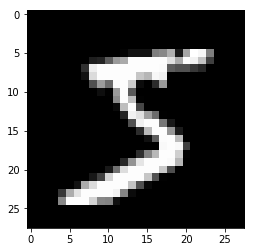

In [5]:
index = 0
plt.imshow(X_train[index].reshape((28,28)),cmap = plt.cm.gray)
print("y is:"+str(np.argmax(y_train[index])))

### 3. 定义数据预处理函数

#### 3.1 定义输入数据转换为二维数组

In [6]:
def im2col2(input_data,fh,fw,stride=1,pad=0):
    '''
     Arguments:     
     input_data--输入数据，shape为(Number of example,Channel,Height,Width)
     fh -- 滤波器的height
     fw --滤波器的width
     stride -- 步幅
     pad -- 填充
     
     Returns :
     col -- 输入数据根据滤波器、步幅等展开的二维数组，每一行代表一条卷积数据
    '''
    N,C,H,W = input_data.shape
    
    out_h = (H + 2*pad - fh)//stride+1
    out_w = (W+2*pad-fw)//stride+1
    
    img = np.pad(input_data,[(0,0),(0,0),(pad,pad),(pad,pad)],"constant")    
    col = np.zeros((N,out_h,out_w,fh*fw*C))
    
    #将所有维度上需要卷积的值展开成一列
    for y in range(out_h):
        y_start = y * stride
        y_end =  y_start + fh
        for x in range(out_w):
            x_start = x*stride
            x_end = x_start+fw
            col[:,y,x] = img[:,:,y_start:y_end,x_start:x_end].reshape(N,-1)
    col = col.reshape(N*out_h*out_w,-1)
    return col

#### 3.2 将二维数组转成 image

In [7]:
def col2im2(col,out_shape,fh,fw,stride=1,pad=0):
    '''
     Arguments:
     col: 二维数组     
     out_shape-- 输出的shape，shape为(Number of example,Channel,Height,Width)
     fh -- 滤波器的height
     fw --滤波器的width
     stride -- 步幅
     pad -- 填充
     
     Returns :
     img -- 将col转换成的img ，shape为out_shape
    '''
    N,C,H,W = out_shape    
    col_m,col_n = col.shape
    
    out_h = (H + 2*pad - fh)//stride+1
    out_w = (W+2*pad-fw)//stride+1

    img = np.zeros((N, C, H , W))

    #将col转换成一个filter
    for c in range(C):
        for y in range(out_h):
            for x in range(out_w):
                col_index = (c*out_h*out_w)+y*out_w+x
                ih = y*stride
                iw =  x*stride
                img[:,c,ih:ih+fh,iw:iw+fw] = col[col_index].reshape((fh,fw))
    return img

In [8]:
def im2col2test():
    a = np.random.randint(0,5,size=(2,3,4,4))
    c = im2col2(a,2,2,2,1)

    a = np.random.randint(0,5,size=(1,1,3,3))
    print(a)
    c = im2col2(a,2,2,1,0)
    print(c)
    col2im2(c,out_shape=(1,1,3,3),fh=2,fw=2,stride=1)

### 4. 定义神经网络参数

#### 4.1 定义激活函数

In [9]:
def relu(input_X):
    
    A = np.where(input_X < 0 ,0,input_X)
    return A

In [10]:
def softmax(input_X):

    exp_a = np.exp(input_X)
    sum_exp_a = np.sum(exp_a,axis=1)
    sum_exp_a = sum_exp_a.reshape(input_X.shape[0],-1)
    ret = exp_a/sum_exp_a
    return ret

#### 4.2 定义损失函数

In [11]:
def cross_entropy_error(labels,logits):
    return -np.sum(labels*np.log(logits))

### 5. 定义卷积神经网络基础层

#### 5.1 定义卷积层

In [12]:
class Convolution:
    def __init__(self,W,fb,stride = 1,pad = 0):
        """
        W-- 滤波器权重，shape为(FN,NC,FH,FW),FN 为滤波器的个数
        fb -- 滤波器的偏置，shape 为(1,FN) 
        stride -- 步长
        pad -- 填充个数
        """
        self.W = W
        self.fb  = fb  
        self.stride = stride
        self.pad = pad
        
        
        self.col_X = None
        self.X = None
        self.col_W = None
        
        self.dW = None
        self.db = None
        self.out_shape = None
        
    def forward (self ,input_X):
        """
        input_X-- shape为(m,nc,height,width)
        """   
        self.X = input_X
        FN,NC,FH,FW = self.W.shape
        
        m,input_nc, input_h,input_w = self.X.shape
    
        #先计算输出的height和widt
        out_h = int((input_h+2*self.pad-FH)/self.stride + 1)
        out_w = int((input_w+2*self.pad-FW)/self.stride + 1)
    
        #将输入数据展开成二维数组，shape为（m*out_h*out_w,FH*FW*C)
        self.col_X = col_X = im2col2(self.X,FH,FW,self.stride,self.pad)
        
        #将滤波器一个个按列展开(FH*FW*C,FN)
        self.col_W = col_W = self.W.reshape(FN,-1).T
        out = np.dot(col_X,col_W)+self.fb
        out = out.T
        out = out.reshape(m,FN,out_h,out_w)
        self.out_shape = out.shape
        return out
    
    def backward(self, dz,learning_rate):

        assert(dz.shape == self.out_shape)
    
        FN,NC,FH,FW = self.W.shape
        o_FN,o_NC,o_FH,o_FW = self.out_shape
        
        col_dz  = dz.reshape(o_NC,-1)
        col_dz = col_dz.T
        
        self.dW = np.dot(self.col_X.T,col_dz)  #shape is (FH*FW*C,FN)
        self.db = np.sum(col_dz,axis=0,keepdims=True)

        
        self.dW = self.dW.T.reshape(self.W.shape)
        self.db = self.db.reshape(self.fb.shape)
        
    
        d_col_x = np.dot(col_dz,self.col_W.T) #shape is (m*out_h*out_w,FH,FW*C)
        dx = col2im2(d_col_x,self.X.shape,FH,FW,stride=1)
        
        assert(dx.shape == self.X.shape)
        
        #更新W和b
        self.W = self.W - learning_rate*self.dW
        self.fb = self.fb -learning_rate*self.db
        
        return dx

#### 5.2 定义汇聚层 (池化层）

In [13]:
class Pooling:
    def __init__(self,pool_h,pool_w,stride = 1,pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad 
        self.X = None
        self.arg_max = None
        
    def forward ( self,input_X) :
        """
        前向传播
        input_X-- shape为(m,nc,height,width)
        """  
        self.X = input_X
        N , C, H, W = input_X.shape
        out_h = int(1+(H-self.pool_h)/self.stride)
        out_w = int(1+(W-self.pool_w)/self.stride)
        
        #展开
        col = im2col2(input_X,self.pool_h,self.pool_w,self.stride,self.pad)
        col = col.reshape(-1,self.pool_h*self.pool_w)
        arg_max = np.argmax(col,axis=1)
        #最大值
        out = np.max(col,axis=1)
        out =out.T.reshape(N,C,out_h,out_w)
        self.arg_max = arg_max
        return out
    
    def backward(self ,dz):
        """
        反向传播
        Arguments:
        dz-- out的导数，shape与out 一致
        
        Return:
        返回前向传播是的input_X的导数
        """ 
        pool_size = self.pool_h*self.pool_w
        dmax = np.zeros((dz.size,pool_size))
        dmax[np.arange(self.arg_max.size),self.arg_max.flatten()] = dz.flatten()
        
        dx = col2im2(dmax,out_shape=self.X.shape,fh=self.pool_h,fw=self.pool_w,stride=self.stride)
        return dx

#### 5.3 定义 ReLu 层

In [14]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self ,X):
        self.mask = X <= 0
        out = X
        out[self.mask] = 0
        return out
    
    def backward(self,dz):
        dz[self.mask] = 0
        dx = dz 
        return dx

#### 5.4 定义 softmax 层

In [15]:
class SoftMax:
    def __init__ (self):
        self.y_hat = None
        
    def forward(self,X):
        
        self.y_hat = softmax(X)
        return self.y_hat
    
    def backward(self,labels):
        m = labels.shape[0]
        dx = (self.y_hat - labels)
        
        return dx

In [16]:
def compute_cost(logits,label):
    return cross_entropy_error(label,logits)

#### 5.4 定义全连接层

In [17]:
class Affine:
    def __init__(self,W,b):
        # shape is (n_x,n_unit)
        self.W = W 
        # shape is(1,n_unit)
        self.b  = b  
        self.X = None
        self.origin_x_shape = None        
        self.dW = None
        self.db = None        
        self.out_shape =None
        
    def forward(self,X):
        self.origin_x_shape = X.shape 
        self.X = X.reshape(X.shape[0],-1)#(m,n)
        out =  np.dot(self.X, self.W)+self.b
        self.out_shape = out.shape
        return out
    
    def backward(self,dz,learning_rate):
        """
        dz-- 前面的导数
        """     
        assert(dz.shape == self.out_shape)
        
        m = self.X.shape[0]
        
        self.dW = np.dot(self.X.T,dz)/m
        self.db = np.sum(dz,axis=0,keepdims=True)/m
        
        assert(self.dW.shape == self.W.shape)
        assert(self.db.shape == self.b.shape)
        
        dx = np.dot(dz,self.W.T)
        assert(dx.shape == self.X.shape)
        
        # 保持与之前的x一样的shape
        dx = dx.reshape(self.origin_x_shape) 
        
        #更新W和b
        self.W = self.W-learning_rate*self.dW
        self.b = self.b - learning_rate*self.db
        
        return dx

### 6. 组合卷积神经网络结构

In [18]:
class SimpleConvNet:

    def __init__(self):
        self.X = None
        self.Y= None
        self.layers = []

    def add_conv_layer(self,n_filter,n_c , f, stride=1, pad=0):
        """
        添加一层卷积层
        Arguments:
        n_c -- 输入数据通道数，也即卷积层的通道数
        n_filter -- 滤波器的个数
        f --滤波器的长/宽

        Return :
        Conv -- 卷积层
        """

        # 初始化W，b
        W = np.random.randn(n_filter, n_c, f, f)*0.01
        fb = np.zeros((1, n_filter))
        # 卷积层
        Conv = Convolution(W, fb, stride=stride, pad=pad)
        return Conv

    def add_maxpool_layer(self, pool_shape, stride=1, pad=0):
        """
        添加一层池化层
        Arguments:
        pool_shape -- 滤波器的shape
        f -- 滤波器大小
        Return :
         Pool -- 初始化的Pool类
        """
        pool_h, pool_w = pool_shape
        pool = Pooling(pool_h, pool_w, stride=stride, pad=pad)
        
        return pool
    
    def add_affine(self,n_x, n_units):
        """
        添加一层全连接层
        Arguments:
        n_x -- 输入个数
        n_units -- 神经元个数
        Return :
        fc_layer -- Affine层对象
        """
        
        W= np.random.randn(n_x, n_units)*0.01
        
        b = np.zeros((1, n_units))
        
        fc_layer = Affine(W,b)
        
        return fc_layer
    
    def add_relu(self):
        relu_layer =  Relu()
        return relu_layer
       
    def add_softmax(self):
        softmax_layer = SoftMax()
        return softmax_layer
    
    #计算卷积或池化后的H和W
    def cacl_out_hw(self,HW,f,stride = 1,pad = 0):
        return (HW+2*pad - f)/stride+1  
    
    def init_model(self,train_X,n_classes):
        """
        初始化一个卷积层网络
        """
        N,C,H,W = train_X.shape
        #卷积层
        n_filter = 4
        f = 7
        
        conv_layer = self.add_conv_layer(n_filter= n_filter,n_c=C,f=f,stride=1)
        
        out_h = self.cacl_out_hw(H,f)
        out_w = self.cacl_out_hw(W,f)
        out_ch = n_filter
        
        self.layers.append(conv_layer)
        
        #Relu
        relu_layer = self.add_relu()
        self.layers.append(relu_layer)
        
        #池化
        f = 2
        pool_layer = self.add_maxpool_layer(pool_shape=(f,f),stride=2)
        out_h = self.cacl_out_hw(out_h,f,stride=2)
        out_w = self.cacl_out_hw(out_w,f,stride=2)
        #out_ch 不改变
        self.layers.append(pool_layer)        
        
        #Affine层
        n_x = int(out_h*out_w*out_ch)
        n_units = 32
        fc_layer = self.add_affine(n_x=n_x,n_units=n_units)
        self.layers.append(fc_layer)
        
        #Relu
        relu_layer = self.add_relu()
        self.layers.append(relu_layer)
        
        #Affine
        fc_layer = self.add_affine(n_x=n_units,n_units=n_classes)
        self.layers.append(fc_layer)
        
        #SoftMax
        softmax_layer = self.add_softmax()
        self.layers.append(softmax_layer)
              
    def forward_progation(self,train_X, print_out = False):
        """
        前向传播
        Arguments:
        train_X -- 训练数据
        f -- 滤波器大小

        Return :
         Z-- 前向传播的结果
         loss -- 损失值
        """           
        N,C,H,W = train_X.shape
        index = 0
        # 卷积层
        conv_layer = self.layers[index]
        X = conv_layer.forward(train_X)
        index =index+1
        if print_out:
            print("卷积之后："+str(X.shape))
        # Relu
        relu_layer =  self.layers[index]
        index =index+1
        X = relu_layer.forward(X)
        if print_out:
            print("Relu："+str(X.shape))
                    
        # 池化层
        pool_layer = self.layers[index]
        index =index+1
        X = pool_layer.forward(X)
        if print_out:
            print("池化："+str(X.shape))

        # Affine层
        fc_layer = self.layers[index]
        index =index+1
        X = fc_layer.forward(X)
        if print_out:
            print("Affline 层的X："+str(X.shape))

        # Relu
        relu_layer = self.layers[index]
        index =index+1
        X = relu_layer.forward(X)
        if print_out:
            print("Relu 层的X："+str(X.shape))
        
        # Affine层
        fc_layer = self.layers[index]
        index =index+1
        X = fc_layer.forward(X)
        if print_out:
            print("Affline 层的X："+str(X.shape))

        # SoftMax层
        sofmax_layer = self.layers[index]
        index =index+1
        A = sofmax_layer.forward(X)
        if print_out:
            print("Softmax 层的X："+str(A.shape))
            
        return A
        
    def back_progation(self,train_y,learning_rate):
        """
        反向传播
        Arguments:
   
        """
        index = len(self.layers)-1
        sofmax_layer = self.layers[index]
        index -= 1
        dz = sofmax_layer.backward(train_y)
        
        fc_layer = self.layers[index]
        dz = fc_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
        relu_layer = self.layers[index]
        dz = relu_layer.backward(dz)
        index -= 1
        
        fc_layer = self.layers[index]
        dz = fc_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
        pool_layer = self.layers[index]
        dz = pool_layer.backward(dz)
        index -= 1
        
        relu_layer =  self.layers[index]
        dz = relu_layer.backward(dz)
        index -= 1
        
        conv_layer = self.layers[index]
        conv_layer.backward(dz,learning_rate=learning_rate)
        index -= 1
        
      
    def get_minibatch(self,batch_data,minibatch_size,num):
        m_examples = batch_data.shape[0]
        minibatches = math.ceil( m_examples / minibatch_size)
 
        if(num < minibatches):
            return batch_data[num*minibatch_size:(num+1)*minibatch_size]
        else:
            return batch_data[num*minibatch_size:m_examples]
    
    
    def optimize(self,train_X, train_y,minibatch_size,learning_rate=0.05,num_iters=500):
        """
        优化方法
        Arguments:
        train_X -- 训练数据 
        train_y -- 训练数据的标签
        learning_rate -- 学习率
        num_iters -- 迭代次数
        minibatch_size 
        """
        m = train_X.shape[0]
        num_batches  = math.ceil(m / minibatch_size)
        
        costs = []
        for iteration in range(num_iters):
            iter_cost = 0
            for batch_num in range(num_batches):
                minibatch_X = self.get_minibatch(train_X,minibatch_size,batch_num)
                minibatch_y = self.get_minibatch(train_y,minibatch_size,batch_num)
                
                # 前向传播
                A = self.forward_progation(minibatch_X,print_out=False)
                #损失:
                cost = compute_cost (A,minibatch_y)
                #反向传播
                self.back_progation(minibatch_y,learning_rate)
                if(iteration%100 == 0):
                    iter_cost += cost/num_batches
                    
            if(iteration%100 == 0):
                print("After %d iters ,cost is :%g" %(iteration,iter_cost))
                costs.append(iter_cost)
                        
        #画出损失函数图
        plt.plot(costs)
        plt.xlabel("iterations/hundreds")
        plt.ylabel("costs")
        plt.show()
        
       
    def predicate(self, train_X):
        """
        预测
        """
        logits = self.forward_progation(train_X)
        one_hot = np.zeros_like(logits)
        one_hot[range(train_X.shape[0]),np.argmax(logits,axis=1)] = 1
        return one_hot   

    def fit(self,train_X, train_y):
        """
        训练
        """
        self.X = train_X
        self.Y = train_y
        n_y = train_y.shape[1]
        m = train_X.shape[0]
        
        #初始化模型
        self.init_model(train_X,n_classes=n_y)

        self.optimize(train_X, train_y,minibatch_size=10,learning_rate=0.05,num_iters=800)
        
        logits = self.predicate(train_X)
        
        accuracy = np.sum(np.argmax(logits,axis=1) == np.argmax(train_y,axis=1))/m
        print("训练集的准确率为：%g" %(accuracy))

### 7. 训练卷积神经网络模型

> **训练预计需要 5 分钟，请耐心等待。**

After 0 iters ,cost is :23.0262
After 100 iters ,cost is :20.5606
After 200 iters ,cost is :19.0754
After 300 iters ,cost is :6.12289
After 400 iters ,cost is :5.53925
After 500 iters ,cost is :6.51583
After 600 iters ,cost is :7.60763
After 700 iters ,cost is :7.23506


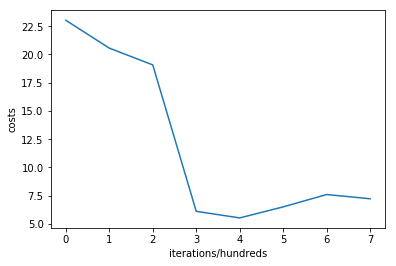

训练集的准确率为：0.6


In [19]:
convNet = SimpleConvNet()

#取前10张图片先做实验
train_X = X_train[0:10]
train_y = y_train[0:10]
convNet.fit(train_X,train_y)

### 8. 卷积神经网络模型验证

In [20]:
logits = convNet.predicate(X_train[0:10])
m = 10
accuracy = np.sum(np.argmax(logits,axis=1) == np.argmax(y_train[0:10],axis=1))/m
print("训练的准确率为：%g" %(accuracy))

训练的准确率为：0.6


图像标签是: 5
你的模型预测结果是: 5


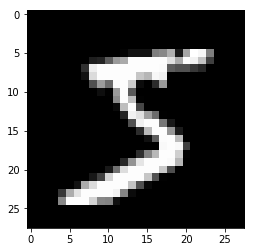

In [21]:
# 使用第一张图片进行测试
index = 0
plt.imshow(X_train[index].reshape((28,28)),cmap = plt.cm.gray)
print("图像标签是: "+str(np.argmax(y_train[index])))
print("你的模型预测结果是: "+str(np.argmax(logits[index])))

### 实验小结

作为本单元小结，在本实验中，我们详细的讨论了卷积神经网络的各种核心概念。之后，通过纯 Python 代码，展示了如何实现相关深度学习核心概念，并且从头构建一个深度学习卷积神经网络。本实验目标仅在于展示完整的卷积神经网络的构建及基础代码实现。很明显，无论从结果还是 MNIST 的基准 (Benchmark) 当前的网络存在大量可以优化和调整的空间 —— 这将留给你来实现！

![](./img/cnn_car.png)